# EDA

В этом нотбуке будет произведен анализ данного нам датасета.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import sys
import os
import json
import pickle
import re
from copy import copy, deepcopy
from collections import defaultdict
from string import punctuation
sys.path.append('..')

import dotenv
import numpy as np
import pandas as pd
from transformers import BertForMaskedLM, BertTokenizer, BertConfig

from deeppavlov.core.data.simple_vocab import SimpleVocabulary

import kenlm
from sacremoses import MosesTokenizer, MosesDetokenizer

from src.models.SpellChecker import *
from src.models.BertScorer.bert_scorer_correction import (
    BertScorerCorrection
)
from src.evaluation.spell_ru_eval import (
    align_sents, levenstein_dist, extract_words
)

from IPython.display import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

[nltk_data] Downloading package punkt to /home/mrgeekman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrgeekman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/mrgeekman/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/mrgeekman/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


In [3]:
PROJECT_PATH = os.path.join(os.path.abspath(''), os.pardir)
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')

## Построение выравнивания

Начнем с того, что найдем какие токены в каждой позиции правильные.

Создадим токенизаторы.

In [4]:
raw_tokenizer = MosesTokenizer(lang='ru')
raw_detokenizer = MosesDetokenizer(lang='ru')
tokenizer = lambda x: raw_tokenizer.tokenize(x, escape=False)
detokenizer = lambda x: raw_detokenizer.detokenize(x)

Прочитаем все предложения.

In [5]:
with open(
    os.path.join(DATA_PATH, 'external', 'spell_ru_eval', 'train_source.txt'), 
    'r'
) as inf:
    sentences = inf.readlines()
    
with open(
    os.path.join(DATA_PATH, 'external', 'spell_ru_eval', 
                 'train_corrected.txt'), 
    'r'
) as inf:
    sentences_corrected = inf.readlines()

Возьмем какое-либо случайное предложение на данный момент.

In [6]:
np.random.seed(42)
idx = np.random.randint(0, len(sentences))

In [7]:
sentence = sentences[idx]
sentence_corrected = sentences_corrected[idx]
print(sentence)
print(sentence_corrected)

Намазывем уже остывший корж " кремом " ( " фромаж блан " или творог, риккота, протертые сквозь мелкое сито, даже густая сметана подойдет ), совсем немного, только, чтобы ягоды потом прилипли.

Намазываем уже остывший корж кремом фромаж блан или творог риккота протертые сквозь мелкое сито даже густая сметана подойдет совсем немного только чтобы ягоды потом прилипли



In [8]:
tokenized_sentence_raw = tokenizer(
    sentence.lower().replace('ё', 'е')
)
tokenized_sentence_corrected = tokenizer(
    sentence_corrected.lower().replace('ё', 'е')
)

Уберем пунктуацию из изначального предложения.

In [9]:
tokenized_sentence = []
indices_mapping = []
for i, token in enumerate(tokenized_sentence_raw):
    if not re.fullmatch(f'[{punctuation}]+', token):
        tokenized_sentence.append(token)
        indices_mapping.append(i)

Пробуем убрать пунктуацию и вывести выравнивание.

In [10]:
alignment = align_sents(tokenized_sentence, tokenized_sentence_corrected)
for pair in alignment:
    left_indices, right_indices = pair
    print(f'{tokenized_sentence[left_indices[0]:left_indices[1]]}\t'
          f'{tokenized_sentence_corrected[right_indices[0]:right_indices[1]]}')

['намазывем']	['намазываем']
['уже']	['уже']
['остывший']	['остывший']
['корж']	['корж']
['кремом']	['кремом']
['фромаж']	['фромаж']
['блан']	['блан']
['или']	['или']
['творог']	['творог']
['риккота']	['риккота']
['протертые']	['протертые']
['сквозь']	['сквозь']
['мелкое']	['мелкое']
['сито']	['сито']
['даже']	['даже']
['густая']	['густая']
['сметана']	['сметана']
['подойдет']	['подойдет']
['совсем']	['совсем']
['немного']	['немного']
['только']	['только']
['чтобы']	['чтобы']
['ягоды']	['ягоды']
['потом']	['потом']
['прилипли']	['прилипли']


Как видим, тут выравнивание оказалось очень простым: 1 к 1. Таким образом, для каждой позиции слева мы нашли корректный токен справа. На пунктуацию можем внимания не обращать, так как она нам не интересна.

**Замечание о токенизации**

Здесь мы будем использовать токенизацию, как в тестирующем скрипте. Токенизация при помощи `MosesTokenizer` обнаруживает 1734 ошибок вместо 1727. Опишем что это за случаи

1. Обработка двоеточий.<br>
Дает четыре дополнительные ошибки. `MosesTokenizer` разделяет строки вида `'18:00'` на три токена: `['18', ':', '00']`, что после выкидывания пунктуации дает ошибку с двоеточием. Токенизатор в тестирующем скрипте работает с этим, как с одним токеном.

2. Обработка дробей.<br>
Дает одну ошибку. Ситуация аналогична обработке двоеточий.

3. Проблема со словом "см.".<br>
Дает одну ошибку. `MosesTokenizer` обрабатывает строку `"см."`, как отдельный токен, а в корректно исправленных предложениях этот токен фигурирует, как `"см"`.

4. Проблема со словом "иметь-".<br>
Дает одну ошибку. `MosesTokenizer` обрабатывает строку `"иметь-"`, как отдельный токен, а в корректно исправленных предложениях этот токен фигурирует, как `"иметь"`.

Теперь такое надо сделать со всеми предложениями в датасете.


In [11]:
def find_corrections(sentence, sentence_corrected):
    """Find corrections of source sentence using corrected sentence."""
    tokenized_sentence_raw = extract_words(sentence)
    tokenized_sentence_corrected = extract_words(sentence_corrected)
    # remove punctuation from source sentence and make mapping 
    # to initial indices
    tokenized_sentence = []
    indices_mapping = []
    for i, token in enumerate(tokenized_sentence_raw):
        if not re.fullmatch(f'[{punctuation}«»]+', token):
            tokenized_sentence.append(token)
            indices_mapping.append(i)
    
    alignment = align_sents(tokenized_sentence, tokenized_sentence_corrected, 
                            return_only_different=True)
    
    mapping = {}
    for i, pair in enumerate(alignment):
        left_indices, right_indices = pair
        mapping[i] = (
            tokenized_sentence[left_indices[0]:left_indices[1]], 
            tokenized_sentence_corrected[right_indices[0]:right_indices[1]]
        )
        
    return mapping, alignment

Выполняем действие над всеми предложениями в обучающем датасете.

In [12]:
corrections = []
alignments = []
for i, (sentence, sentence_corrected) in enumerate(
    zip(sentences, sentences_corrected)
):
    corrections_sentence, alignment = find_corrections(
        sentence, sentence_corrected
    )
    corrections.append(corrections_sentence) 
    alignments.append(alignment)

Убедимся, что собраны все предложения.

In [13]:
len(corrections)

2000

Посмотрим, как выглядит элемент выборки.

In [14]:
corrections[0]

{0: (['ктобы'], ['кто', 'бы']), 1: (['не'], ['ни'])}

## Анализ

Теперь будем проводить анализ полученного датасета. Начнем с того, что подсчитаем количества ошибок различных типов.

### Количества ошибок

Всего ошибок:

In [15]:
nums_corrections = []
for corrections_sentence in corrections:
    nums_corrections.append(len(corrections_sentence))
    
nums_corrections = np.array(nums_corrections)
num_corrections = np.sum(nums_corrections)

In [16]:
print(f'Всего исправлений: {num_corrections}')

Всего исправлений: 1727


Получили ровно то количество ошибок, которое наблюдается после тестирования.

**Распределение количеств исправлений**

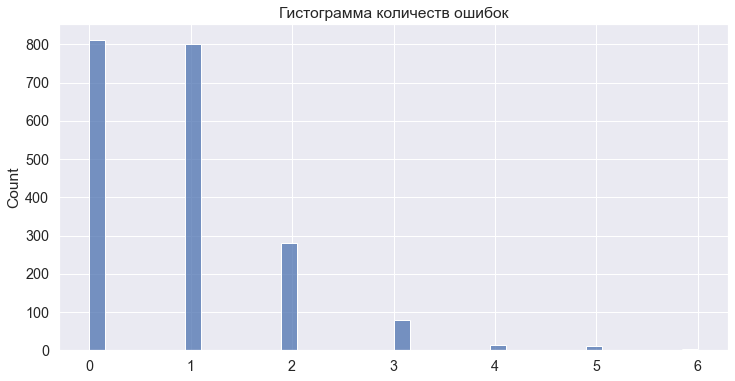

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(nums_corrections)
plt.title('Гистограмма количеств ошибок')
plt.show()

In [18]:
values, counts = np.unique(nums_corrections, return_counts=True)
for value, count in zip(values, counts):
    print(f'{value} : {count} : {count/len(nums_corrections):.3f}')

0 : 812 : 0.406
1 : 801 : 0.401
2 : 280 : 0.140
3 : 79 : 0.040
4 : 14 : 0.007
5 : 11 : 0.005
6 : 3 : 0.002


1. Около $40\%$ предложений не требуют исправлений вообще
2. В одном предложении чаще всего или нет исправлений или одно. Доля предложений с количеством исправлений больше трех составляет около $1.5 \%$.

Теперь найдем количества ошибок разных типов.

**Один к одному**

Посмотрим, как часто один токен просто заменяется на другой токен.

In [19]:
num_one_to_one = 0
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 1 and len(corrected) == 1:
            num_one_to_one += 1

In [20]:
print(f'Исправлений одного токена на другой один токен: {num_one_to_one}')
print(f'Доля исправлений одного токена на другой один токен: '
      f'{num_one_to_one/num_corrections:.3f}')

Исправлений одного токена на другой один токен: 1381
Доля исправлений одного токена на другой один токен: 0.800


Как видим, целых $80\%$ ошибок &mdash; это исправление одного токена на другой токен.

**Один к нескольким**

Посмотрим, как часто один токен исправляется на несколько и каковы в таком случае соотношения.

In [21]:
num_one_to_many = []
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 1 and len(corrected) > 1:
            num_one_to_many.append(len(corrected))

In [22]:
print(f'Исправлений одного токена на несколько: {len(num_one_to_many)}')
print(f'Доля исправлений одного токена на несколько: '
      f'{len(num_one_to_many)/num_corrections:.3f}')

Исправлений одного токена на несколько: 270
Доля исправлений одного токена на несколько: 0.156


Посмотрим на распределения значений.

In [23]:
nums_tokens, nums_cases = np.unique(num_one_to_many, return_counts=True)
for num_tokens, num_cases in zip(nums_tokens, nums_cases):
    print(f'Количество замен одного токена на {num_tokens}: {num_cases}')

Количество замен одного токена на 2: 262
Количество замен одного токена на 3: 8


Как видим, существует несколько случаев замены одного токена на целых три. Посмотрим на них.

In [24]:
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 1 and len(corrected) == 3:
            print(correction)

(['инагоночных'], ['и', 'на', 'гоночных'])
(['вконтактепро'], ['в', 'контакте', 'про'])
(['незнаюкто'], ['не', 'знаю', 'кто'])
(['тачтосидит'], ['та', 'что', 'сидит'])
(['тойчтостоит'], ['той', 'что', 'стоит'])
(['незачто'], ['не', 'за', 'что'])
(['незанающиеграниц'], ['не', 'знающие', 'границ'])
(['ктомуже'], ['к', 'тому', 'же'])


Выглядит, как достаточно редкий случай.

**Несколько к одиному**

Посмотрим, как часто несколько токенов исправляется на один и каковы в таком случае соотношения.

In [25]:
num_many_to_one = []
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) > 1 and len(corrected) == 1:
            num_many_to_one.append(len(source))

In [26]:
print(f'Исправлений нескольких токенов на один: {len(num_many_to_one)}')
print(f'Доля исправлений нескольких токенов на один: '
      f'{len(num_many_to_one)/num_corrections:.3f}')

Исправлений нескольких токенов на один: 70
Доля исправлений нескольких токенов на один: 0.041


Посмотрим на распределения значений.

In [27]:
nums_tokens, nums_cases = np.unique(num_many_to_one, return_counts=True)
for num_tokens, num_cases in zip(nums_tokens, nums_cases):
    print(f'Количество замен одного токена на {num_tokens}: {num_cases}')

Количество замен одного токена на 2: 69
Количество замен одного токена на 3: 1


Как видим, существует несколько случаев замены одного токена на целых три. Посмотрим на них.

In [28]:
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 3 and len(corrected) == 1:
            print(correction)

(['прочего', 'прочего', 'прочего'], ['прочего-прочего-прочего'])


Выглядит, как достаточно редкий случай.

А теперь попробуем выделить некоторые конкретные типы ошибок, которые тут могли быть:
1. Лишний пробел в слове. 
2. Пробел вместо дефиса.

In [29]:
extra_space = 0
need_hyphen = 0
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 2 and len(corrected) == 1:
            if source[0] + source[1] == corrected[0]:
                extra_space += 1
            elif source[0] + '-' + source[1] == corrected[0]:
                need_hyphen += 1
            else:
                print(correction)

(['не', 'допонемание'], ['недопонимание'])
(['што', 'бы'], ['чтобы'])
(['розврат', 'то'], ['разврат-то'])
(['потохоньку', 'полегоньку'], ['потихоньку-полегоньку'])
(['лапмочку', 'то'], ['лампочку-то'])
(['што', 'нить'], ['что-нибудь'])
(['не', 'каких'], ['никаких'])
(['оптять', 'таки'], ['опять-таки'])
(['24х', 'летие'], ['24-летие'])
(['какой', 'то'], ['какое-то'])
(['мееедленно', 'мееедленно'], ['медленно-медленно'])
(['что', 'нибуь'], ['что-нибудь'])


In [30]:
print(f'Количество случаев, когда стоит ненужный пробел: {extra_space}')
print(f'Количество случаев, когда стоит пробел вместо дефиса: {need_hyphen}')

Количество случаев, когда стоит ненужный пробел: 26
Количество случаев, когда стоит пробел вместо дефиса: 31


Как видим, почти все случаи этой ошибки относятся всего к двум простым категориям. Правда, пара случаев из них не очень приятные из-за соединения числа и слова, например "15 летней" вместо "15-летней".

**Несколько к нескольким**

In [31]:
num_many_to_many = []
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) > 1 and len(corrected) > 1:
            num_many_to_many.append((len(source), len(corrected)))

In [32]:
print(f'Исправлений нескольких токенов на несколько: {len(num_many_to_many)}')
print(f'Доля исправлений нескольких токенов на несколько: '
      f'{len(num_many_to_many)/num_corrections:.3f}')

Исправлений нескольких токенов на несколько: 3
Доля исправлений нескольких токенов на несколько: 0.002


Как видим, это крайне редкие случаи, посмотрим на них:

In [33]:
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) > 1 and len(corrected) > 1:
            print(correction)

(['вообщем', 'то'], ['в', 'общем-то'])
(['сос', 'тарыми'], ['со', 'старыми'])
(['вообщем', 'то'], ['в', 'общем-то'])


Видим, что два случая вообще одинаковы.

### Расстояния Дамерау-Левенштейна

Теперь изучим каково распределение расстояний Дамерау-Левенштейна.

In [34]:
distances = []
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        source_str = ' '.join(source)
        corrected_str = ' '.join(corrected)
        distance = levenstein_dist(source_str, corrected_str)
        distances.append(distance)

In [35]:
distance_values, nums_cases = np.unique(distances, return_counts=True)
for distance, num_cases in zip(distance_values, nums_cases):
    print(f'Количество коррекций с расстоянием {int(distance)}: '
          f'{num_cases}/{num_corrections} ~ {num_cases/num_corrections:.3f}')

Количество коррекций с расстоянием 1: 1333/1727 ~ 0.772
Количество коррекций с расстоянием 2: 267/1727 ~ 0.155
Количество коррекций с расстоянием 3: 80/1727 ~ 0.046
Количество коррекций с расстоянием 4: 31/1727 ~ 0.018
Количество коррекций с расстоянием 5: 11/1727 ~ 0.006
Количество коррекций с расстоянием 6: 4/1727 ~ 0.002
Количество коррекций с расстоянием 10: 1/1727 ~ 0.001


Как видим, около $93\%$ случаев требуют исправления на расстоянии, не превышающем два.

### Candidate Generator

В этом разделе мы проанализируем работу компоненты candidage generator.

#### Полнота словаря

Посмотрим насколько часто правильные исправления есть в используемом нами словаре. Если их там нет, то модель будет ограничена в том, чтобы исправлять такие ошибки.

Загрузим словарь:

In [36]:
vocab_path = os.path.join(
    DATA_PATH, 'external', 'russian_words', 'russian_words_vocab.dict'
)
vocab = set(SimpleVocabulary(load_path=vocab_path, save_path=vocab_path))

2021-02-28 12:55:11.285 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /home/mrgeekman/Documents/MIPT/НИР/Repo/data/external/russian_words/russian_words_vocab.dict]


Размер словаря:

In [37]:
print(f'Размер словаря: {len(vocab)}')

Размер словаря: 1531456


Как видим, словарь весьма большой, почти $1.5$ млн слов.

А теперь проверим как много слов из корректных исправлений наш словарь не знает. Так как мы работаем только с теми местами, где исправления нужны, то игнорируем случай, когда модели нужно не трогать незнакомое ей слово.

In [38]:
unknown_words = defaultdict(int)
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        for word in corrected:
            if word not in vocab:
                unknown_words[word] += 1

In [39]:
keys = np.array(list(unknown_words.keys()))
values = np.array(list(unknown_words.values()))
indices_sorted = np.argsort(-values)
keys = keys[indices_sorted]
values = values[indices_sorted]

Выведем для каждого несловарного слова его само и его частоту.

In [40]:
for key, value in zip(keys, values):
    print(f'{key}: {value}')

наконец-то: 7
общем-то: 4
по-любому: 4
какие-то: 2
какое-то: 2
повтыкав: 1
отрисовала: 1
перкуссионист: 1
какая-то: 1
онтогенетически: 1
очень-очень: 1
строительно-магазинное: 1
мегапозитивные: 1
азербайджан: 1
депрессняк: 1
4-х: 1
спецпсихологии: 1
мачо: 1
стартапу: 1
веб-камеру: 1
мегапиковой: 1
варикозе: 1
кому-то: 1
сами-то: 1
дауни-младший: 1
рязань: 1
постебался: 1
прочего-прочего-прочего: 1
пофотографировав: 1
тихо-тихо: 1
аборигенку: 1
обрызгивается: 1
рaда: 1
видео-репортаж: 1
медленно-медленно: 1
очень-то: 1
скриншот: 1
расставаньям: 1
24-летие: 1
вообще-то: 1
рок-н-ролла: 1
репбазы: 1
электрокнигу: 1
горсобрания: 1
папилломовирус: 1
предыдущих-последующих: 1
папилломавирусы: 1
рекомендуемо: 1
шкварчать: 1
40-летней: 1
15-летней: 1
60-х: 1
коммент: 1
рок-звезда: 1
разврат-то: 1
любви-то: 1
встретил-таки: 1
кого-нибудь: 1
напроектировали: 1
чем-то: 1
дом-2: 1
колясочников: 1
самой-то: 1
девчонки-продавцы: 1
шмотья: 1
монголоидом: 1
по-взрослому: 1
гулливера: 1
таиланд: 1
викто

Как видим, большинство слов встречаются лишь один раз, но есть и особо частые случаи.

In [41]:
print(f'Всего несловарных слов: {len(keys)}')
print(f'Всего несловарных случаев: {np.sum(values)}')

Всего несловарных слов: 91
Всего несловарных случаев: 105


Таким образом, около сотни ошибок мы не можем исправить в принципе, потому что просто не имеем таких словарных слов.

Возможные решения:
1. Внести все те слова, что у нас нет.
2. Внести в словарь лишь те слова, что имеют частоту, большую одного.
3. Поискать более хороший словарь. Этот способ позволит избежать похожих ошибок еще и на этапе тестирования.

#### Работа `PhoneticSearcher`

Компонента candidate generator имеет внутри себя алгоритм для фонетического поиска слова. Попробуем провести какую-то аналитику для него. 

In [42]:
phonetic_searcher = PhoneticSeacher(vocab)

В первую очередь интересно как часто он помогает, если слова находятся на расстоянии Левенштейна, большим одного. Рассматривать работу будем только на случае один к одному, так как `PhoneticSearcher` не умеет работать со строками с пробелами внутри.

In [43]:
distances = []
is_succ = []
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 1 and len(corrected) == 1:
            source = source[0]
            corrected = corrected[0]
            distance = levenstein_dist(source, corrected)
            if distance > 1:
                distances.append(distance)
                candidates = phonetic_searcher([[source]])[0][0]
                if corrected in candidates:
                    is_succ.append(True)
                else:
                    is_succ.append(False)
                    
is_succ = np.array(is_succ)
distances = np.array(distances)

In [44]:
print(f'Количество успешных нахождений кандидатов: '
      f'{np.sum(is_succ)}/{len(is_succ)} ~ {np.mean(is_succ):.3f}')

Количество успешных нахождений кандидатов: 110/341 ~ 0.323


Выглядит не так уж и плохо.

Посмотрим на то, как распределены расстояния, с на которых нам удается найти кандидатов.

In [45]:
distance_values, nums_cases = np.unique(distances, return_counts=True)
for distance, num_cur_cases in zip(distance_values, nums_cases):
    cur_is_succ = is_succ[distances == distance]
    print(f'Количество коррекций с расстоянием {int(distance)}: '
          f'{np.sum(cur_is_succ)}/{len(cur_is_succ)} ~ '
          f'{np.mean(cur_is_succ):.3f}')

Количество коррекций с расстоянием 2: 65/230 ~ 0.283
Количество коррекций с расстоянием 3: 28/75 ~ 0.373
Количество коррекций с расстоянием 4: 15/26 ~ 0.577
Количество коррекций с расстоянием 5: 1/5 ~ 0.200
Количество коррекций с расстоянием 6: 0/4 ~ 0.000
Количество коррекций с расстоянием 10: 1/1 ~ 1.000


Как видим, эта компонента не очень хорошо помогает доставать кандидатов с расстояния два, но позволяет доставать и с больших расстояний. Дело в том, что достаточно часто кандидаты на большом расстоянии содержат дублирующиеся гласные, с которыми `PhoneticSearcher` умеет работать. В качестве примера, "ооочень" вместо "очень".

#### Работа `HandcodeSearcher`

Проведем аналогичный анализ для `HandcodeSearcher`.

In [46]:
handcode_table_path = os.path.join(
    DATA_PATH, 'processed', 'handcode_table', 'table.json'
)
with open(handcode_table_path, 'r') as inf:
    handcode_table = json.load(inf)

handcode_searcher = HandcodeSearcher(handcode_table)

In [47]:
distances = []
is_succ = []
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 1 and len(corrected) == 1:
            source = source[0]
            corrected = corrected[0]
            distance = levenstein_dist(source, corrected)
            if distance > 1:
                distances.append(distance)
                candidates = handcode_searcher([[source]])[0][0]
                if corrected in candidates:
                    is_succ.append(True)
                else:
                    is_succ.append(False)
                    
is_succ = np.array(is_succ)
distances = np.array(distances)

In [48]:
print(f'Количество успешных нахождений кандидатов: '
      f'{np.sum(is_succ)}/{len(is_succ)} ~ {np.mean(is_succ):.3f}')

Количество успешных нахождений кандидатов: 99/341 ~ 0.290


Тоже выглядит вполне себе неплохо.

Посмотрим на распределение расстояний.

In [49]:
distance_values, nums_cases = np.unique(distances, return_counts=True)
for distance, num_cur_cases in zip(distance_values, nums_cases):
    cur_is_succ = is_succ[distances == distance]
    print(f'Количество коррекций с расстоянием {int(distance)}: '
          f'{np.sum(cur_is_succ)}/{len(cur_is_succ)} ~'
          f' {np.mean(cur_is_succ):.3f}')

Количество коррекций с расстоянием 2: 54/230 ~ 0.235
Количество коррекций с расстоянием 3: 31/75 ~ 0.413
Количество коррекций с расстоянием 4: 7/26 ~ 0.269
Количество коррекций с расстоянием 5: 4/5 ~ 0.800
Количество коррекций с расстоянием 6: 3/4 ~ 0.750
Количество коррекций с расстоянием 10: 0/1 ~ 0.000


Видим, что опять удается достать лишь небольшое число кандидатов на расстоянии два.

#### Работа `PhoneticSearcher` и `HandcodeSearcher`

А теперь посмотрим насколько хорошо эти модели действуют в тандеме.

In [50]:
distances = []
is_succ = []
for corrections_sentence in corrections:
    for _, correction in corrections_sentence.items():
        source, corrected = correction
        if len(source) == 1 and len(corrected) == 1:
            source = source[0]
            corrected = corrected[0]
            distance = levenstein_dist(source, corrected)
            if distance > 1:
                distances.append(distance)
                candidates = (
                    phonetic_searcher([[source]])[0][0] 
                    + handcode_searcher([[source]])[0][0]
                )
                if corrected in candidates:
                    is_succ.append(True)
                else:
                    is_succ.append(False)
                    
is_succ = np.array(is_succ)
distances = np.array(distances)

In [51]:
print(f'Количество успешных нахождений кандидатов: '
      f'{np.sum(is_succ)}/{len(is_succ)} ~ {np.mean(is_succ):.3f}')

Количество успешных нахождений кандидатов: 204/341 ~ 0.598


Видим очень небольшое пересечение `PhoneticSearcher` и `HandcodeSearcher` &mdash; 5 кандидатов.

Посмотрим на распределение расстояний.

In [52]:
distance_values, nums_cases = np.unique(distances, return_counts=True)
for distance, num_cur_cases in zip(distance_values, nums_cases):
    cur_is_succ = is_succ[distances == distance]
    print(f'Количество коррекций с расстоянием {int(distance)}: '
          f'{np.sum(cur_is_succ)}/{len(cur_is_succ)} ~ '
          f'{np.mean(cur_is_succ):.3f}')

Количество коррекций с расстоянием 2: 115/230 ~ 0.500
Количество коррекций с расстоянием 3: 58/75 ~ 0.773
Количество коррекций с расстоянием 4: 22/26 ~ 0.846
Количество коррекций с расстоянием 5: 5/5 ~ 1.000
Количество коррекций с расстоянием 6: 3/4 ~ 0.750
Количество коррекций с расстоянием 10: 1/1 ~ 1.000


Видно, что самая большая проблема со словами на расстоянии Дамерау-Левенштейна, равном двум.

#### Механизм объединения токенов

Исследуем насколько хорошо работает наш механизм объединения токенов для обработки ошибок "несколько на один". Мы просматриваем пары последовательных токенов, объединяя их через пробел, и если мы находим в словаре слово после удаления пробела или его замены на дефис, то формируем следующий список кандидатов:
1. Изначальные два токена.
2. Кандидаты сразу для пары токенов, полученные удалением пробела или его заменой на дефис. 
3. Неизменный первый токен + кандидаты для второго токена.
4. Кандидаты для первого токена + неизменный второй токен.

Такой механизм в теории позволяет бороться с лишними объединениями, так как мы можем по-прежнему выбрать какие-то исправления.

In [53]:
del phonetic_searcher, handcode_searcher
gc.collect()
candidate_generator = CandidateGenerator(
    words=vocab, handcode_table=handcode_table, max_distance=1
)

In [54]:
many_to_one_alignments = set()
cnt = 0
for num_sent, alignment in enumerate(alignments):
    for left_indices, right_indices in alignment:
        if (
            left_indices[1] - left_indices[0] == 2 
            and right_indices[1] - right_indices[0] == 1
        ):
            many_to_one_alignments.add(
                (num_sent, 
                 (left_indices[0], left_indices[1]-1))
            )

Здесь воспользуемся `MosesTokenizer` и удалением пунктуации уже после процедуры объединения, потому что именно так это будет работать в нашей модели. Объединять лучше до удаления пункуации, потому что часто она может спасти от объединения слов, которые могли бы быть объединены без нее.

In [55]:
def find_combinations(sentence):
    tokenized_sentence_raw = tokenizer(sentence)
    candidates = candidate_generator([tokenized_sentence_raw])
    results_combined = candidate_generator.combine_tokens(candidates)
    candidates_combined, indices_combined = results_combined
    
    # remove punctuation from source sentence and make mapping 
    # to initial indices
    tokenized_sentence = []
    indices_mapping = []
    for i, token in enumerate(tokenized_sentence_raw):
        if not re.fullmatch(f'[{punctuation}«»]+', token):
            tokenized_sentence.append(token)
            indices_mapping.append(i)
    indices_inv_mapping = {
        value: idx for idx, value in enumerate(indices_mapping)
    }
    
    combinations = []
    for indices in indices_combined[0]:
        if len(indices) == 2:
            combinations.append((
                indices_inv_mapping[indices[0]],
                indices_inv_mapping[indices[1]]
            ))
    return combinations

In [56]:
combinations = set()
for num_sent, sentence in tqdm(enumerate(sentences), total=len(sentences)):
    combinations_sentence = find_combinations(sentence)
    for combination in combinations_sentence:
        combinations.add((num_sent, tuple(combination)))

Теперь подсчитаем насколько хорошо нашей модели удается делать объединения.

In [57]:
TP = len(combinations.intersection(many_to_one_alignments))
precision = TP / len(combinations)
recall = TP / len(many_to_one_alignments)
print(f'TP = {TP}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')

TP = 39
Precision = 0.071
Recall = 0.565


Как видим, модель выявляет только около половины ошибок и срабатывает не в нужный момент очень часто. 

Проблема с большим числом ложных срабатываний кроется в том, что в словаре часто находятся слова, которые подходят под объединение. 

Проблема с малым recall в том, что многих слов нет в словаре, например "любви-то".

### Position Selector

См. в ноутбуке `9.0-db-learning_advanced_position_selector`, который посвящен улучшению стандартной версии position selector.

### Candidate Scorer

См. в ноутбуке `7.0-db-learning_advanced_scorer`, который посвящен улучшению стандартной версии candidate scorer.

### Выводы

1. Был проведен анализ частот различного типа ошибок.
2. Было обнаружено, что порядка сотни ошибок связаны с отсутствием корректных исправлений в словаре.
3. Было обнаружено, что `PhoneticSearcher` и `HandcodeSearcher` достаточно хорошо покрывают ошибки на расстоянии Дамерау-Левеншейна, большем двух.